# Example of Pandas-TA technical indicators with multiple plot backends

The plotting backends will be matplotlib, plotly, and bokeh mostly. Matplotlib is flexible, but not dynamic, and the others are dynamic, but don't have all the features that matplotlib has. The most problematic for technical analysis are related to the need to shade segments of indicator lines differently according to some criteria, or to shade areas between lines, shade them differently, or shading histogram bars differently. All of these present some issues, and we show below how to use Pandas-TA and some backends to achieve the functionality you would expect from some indicators.

In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta

import yfinance as yf
symbol = 'XOM'
tickerdata = yf.download(symbol, period='1mo', interval='1h')
tickerdata.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 155 entries, 2023-09-11 09:30:00-04:00 to 2023-10-10 16:00:00-04:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       155 non-null    float64
 1   High       155 non-null    float64
 2   Low        155 non-null    float64
 3   Close      155 non-null    float64
 4   Adj Close  155 non-null    float64
 5   Volume     155 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 8.5 KB


## TMO: True Momentum Oscillator

The references provided denote a normalized TMO in the $[-100,100]$ range, and its moving average, with two more moving averages for a *main signal* and *smooth signal* assisting the analysis. The *main signal* is colored green or red, if above or below the *smooth signal* respectively, and we add a histogram to this difference as well for readability.

In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from pandas_ta.momentum import tmo

In [6]:
# True Momentum Oscillator calculation
tmo_length = 14
calc_length = 5
smooth_length = 3
compute_momentum = True
normalize_signum = False

data = tmo(
    tickerdata["Open"], tickerdata["Close"], 
    tmo_length=tmo_length, calc_length=calc_length, smooth_length=smooth_length, 
    mamode="ema", compute_momentum=compute_momentum, normalize_signum=normalize_signum)

data.dropna()
data = data.dropna().reset_index()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype                           
---  ------                 --------------  -----                           
 0   index                  120 non-null    datetime64[ns, America/New_York]
 1   TMO_14_5_3             120 non-null    float64                         
 2   TMO_Smooth_14_5_3      120 non-null    float64                         
 3   TMO_Main_Mom_14_5_3    120 non-null    float64                         
 4   TMO_Smooth_Mom_14_5_3  120 non-null    float64                         
dtypes: datetime64[ns, America/New_York](1), float64(4)
memory usage: 4.8 KB


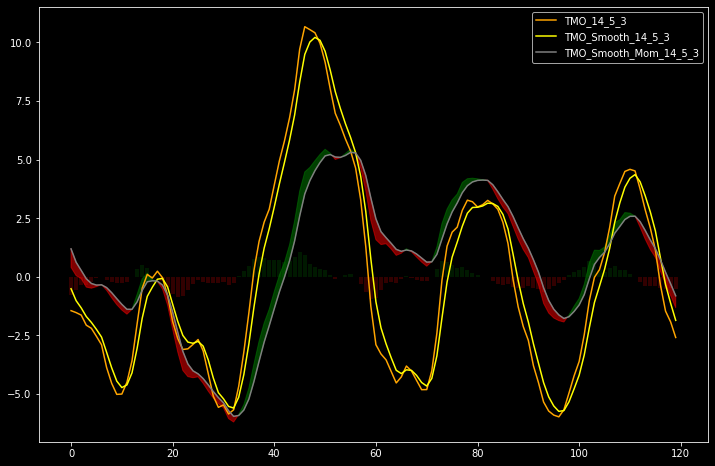

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot momentum lines, but the dataframe can contain any parameter names combination
# so access by index position as seen above in the data.info() 
tmo_main = data.iloc[:, 1]
tmo_smooth = data.iloc[:, 2]

if compute_momentum is True:
    tmo_main_mom = data.iloc[:, 3]
    tmo_smooth_mom = data.iloc[:, 4]
    ax.plot(data.index, tmo_main_mom, color='orange', label=data.columns[1])
    ax.plot(data.index, tmo_smooth_mom, color='yellow', label=data.columns[2])
    
# Plot Smooth Signal
ax.plot(data.index, tmo_smooth, color='grey', label=data.columns[4])

# Conditional fill between Main Signal and Smooth Signal
ax.fill_between(data.index, tmo_main, tmo_smooth, 
                where=(tmo_main > tmo_smooth), interpolate=True, color='green', alpha=0.5)
ax.fill_between(data.index, tmo_main, tmo_smooth, 
                where=(tmo_main <= tmo_smooth), interpolate=True, color='red', alpha=0.5)

# Adding histogram
colors = ['g' if main > smooth else 'r' for main, smooth in zip(tmo_main, tmo_smooth)]
ax.bar(data.index, tmo_main - tmo_smooth, color=colors, alpha=0.2)

plt.legend()
plt.show()